In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os.path as op
import time

from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
from keras.datasets import cifar10
import seaborn as sns
from skimage import color

from fastmri_recon.data.test_generators import RandomShapeGenerator
from fastmri_recon.data.test_generators import CifarGenerator
from fastmri_recon.helpers.adversarial_training import compile_models, adversarial_training_loop
from fastmri_recon.helpers.image_tboard_cback import TensorBoardImage
from fastmri_recon.helpers.keras_utils import wasserstein_loss
from fastmri_recon.models.discriminator import discriminator_model, generator_containing_discriminator_multiple_outputs
from fastmri_recon.models.unet import unet
from fastmri_recon.helpers.utils import keras_ssim, keras_psnr
from fastmri_recon.helpers.evaluate import psnr, ssim, mse, nmse
from fastmri_recon.helpers.fourier import fft
from fastmri_recon.helpers.utils import gen_mask
from fastmri_recon.helpers.reconstruction import zero_filled_recon

Using TensorFlow backend.


In [2]:
run_params = {
    'n_layers': 4, 
    'pool': 'max', 
    "layers_n_channels": [16, 32, 64, 128], 
    'layers_n_non_lins': 2,
}

im_size = 32

def generator_model():
    model = unet(input_size=(im_size, im_size, 1), **run_params, compile=False)
    model.name = 'Reconstructor'
    return model

In [3]:
g = generator_model()
g_opt = Adam(lr=1e-3, clipnorm=1.)
g.compile(optimizer=g_opt, loss='mse', metrics=[keras_psnr, keras_ssim])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [4]:
def show_images(images, cols = 1, title=None, titles = None, scale = 1, save=False):
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(facecolor="white")
    with sns.color_palette("PuBuGn_d"):
        for n, (image, title) in enumerate(zip(images, titles)):
            a = fig.add_subplot(cols, np.ceil(n_images/float(cols)) +1 , n + 1)
            plt.imshow(image, )
            a.set_title(title)
    #plt.colorbar()
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images * scale)
    if save:
        plt.savefig("/Users/WorkAccount/Desktop/generator_outputs")
    plt.show()

In [29]:
def alias_set(x_train):
    images = np.empty(x_train.shape)
    kspaces = np.empty(x_train.shape)
    images = np.expand_dims(np.squeeze(images), axis=3)
    kspaces = np.expand_dims(kspaces, axis=3)
    for i in range(len(x_train)):
        image = x_train[i]
        image = image.astype('float32')
        image /= 255
        kspace = fft(image)
        mask = gen_mask(kspace, accel_factor=2)
        kspace *= mask
        images[i, ..., 0] = image
        kspaces[i, ..., 0] = kspace
    recons = zero_filled_recon(kspaces[..., 0], crop=False)[..., None]
    return np.expand_dims(np.squeeze(recons), axis=3), np.expand_dims(np.squeeze(x_train), axis=3)

In [39]:
n_batches_train = 1000
n_batches_val = 1
AF = 2

(x_train, _), (x_test, _) = cifar10.load_data()

x_train = color.rgb2gray(x_train)
x_test = color.rgb2gray(x_test)

testgen = CifarGenerator(AF, im_size, x_train).flow_z_filled_random_shapes()

recons, images = alias_set(x_train)
val_recons, val_images = alias_set(x_test)


x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

print(x_train.shape, x_test.shape, recons.shape, images.shape, val_recons.shape, val_images.shape, )


/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


(50000, 32, 32, 1) (10000, 32, 32, 1) (50000, 32, 32, 1) (50000, 32, 32, 1) (10000, 32, 32, 1) (10000, 32, 32, 1)


In [40]:
def ali(tup):
    return np.squeeze(tup[0])
def og(tup):
    return np.squeeze(tup[1])

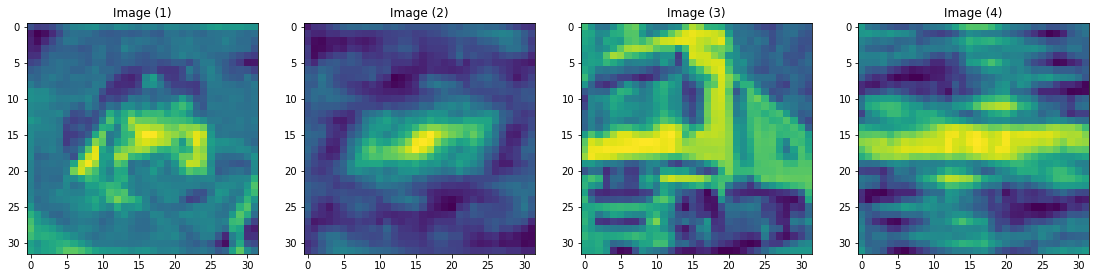

In [43]:
show_images([np.squeeze(images[0]), np.squeeze(recons[0]), np.squeeze(images[1]), np.squeeze(recons[1])])
im = next(testgen)
iim = next(testgen)
show_images([og(im), ali(im), og(iim), ali(iim)])

In [ ]:
epoch_num = 100

run_id = f'gen_af{AF}_{int(time.time())}'
chkpt_path = f'checkpoints/{run_id}' + '-{epoch:02d}.hdf5'
print(run_id)

In [ ]:
i=2
show_images([np.squeeze(x_train[i]), np.squeeze(images[i]), np.squeeze(recons[i])], titles=['base', 'true', "zero_filled"])

In [ ]:
tqdm_cb = TQDMNotebookCallback(metric_format="{name}: {value:e}")
chkpt_cback = ModelCheckpoint(chkpt_path, period=epoch_num)

In [ ]:
val_recons.shape

In [ ]:
%%time
hist = g.fit(x=recons[:30000][:][:],
             y=images[:30000][:][:],
             epochs=200, callbacks=[tqdm_cb, chkpt_cback],
             batch_size=200,
             validation_data=(val_recons[:6000][:][:], val_images[:6000][:][:]))

In [ ]:
def show_prediction(g, im_true, im_alias):
    im_true = np.expand_dims(im_true, axis=3)
    im_alias = np.expand_dims(im_alias, axis=0)
    im_pred =  g.predict(im_alias)
    im_true = np.squeeze(im_true)
    im_alias = np.squeeze(im_alias)
    im_pred = np.squeeze(im_pred)
    print(im_pred.shape, im_true.shape, im_alias.shape)
    show_images([im_true, im_alias, im_pred], titles=["true", "aliased", "predicted"])
    print("PSNR aliased image: ", psnr(im_true, im_alias), "\nPSNR predicted image:", psnr(im_true, im_pred))
    print("\nMSE aliased image: ", mse(im_true, im_alias), "\nMSE predicted image:", mse(im_true, im_pred))
    print("\nNMSE aliased image: ", nmse(im_true, im_alias), "\nNMSE predicted image:", nmse(im_true, im_pred))
    

In [ ]:
i = 2
show_prediction(g, val_images[i], val_recons[i])
# im_pred =  g.predict(im_alias)
# show_images([np.squeeze(im_true), np.squeeze(im_alias), np.squeeze(im_pred)], titles=["true", "aliased", "predicted"])

In [ ]:
%mkdir training_plots

In [ ]:
x = [l for l in hist.history]
print(x)

In [ ]:
val = True
fig, axs = plt.subplots(2,2,figsize=(13,15))
images = [hist.history[l] for l in hist.history]
titles = [l for l in hist.history]
if val==True:
    for i in range(len(titles)//2):
        plt.subplot(3, 1, i+1)
        plt.plot(images[i], label='validation')
        print('validation', titles[i])
        plt.plot(images[i+3], label='training')
        print('training', titles[i+3])
        plt.title(titles[i])
        plt.legend()
else:
    for i in range(len(titles)):
        plt.subplot(3, 1, i+1)
        plt.plot(images[i])
        plt.title(titles[i])
        plt.legend()
    plt.show()
plt.savefig("./training_plots/lr3_val")
plt.show()

In [ ]:
!ls checkpoints

![](http://)![](http://)![](http://)<a href='./fastmri-reproducible-benchmark/checkpoints/gen_af2_1574688454-100.hdf5'> Download model </a>